In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  
from scipy.spatial import distance  
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  
from dotenv import load_dotenv
load_dotenv()
import os
import wandb
wandb.login(key=os.getenv("WANDB_APIKEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hp\_netrc


True

In [9]:
wandb.init(project='preesha_MLPR_lab-5')
image = cv2.imread("Plaksha_Faculty.jpg")  # reading img
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting img to greyscale

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") # loading XML classifier file

# Apply face detection on the grayscale image
## Adjust parameters for better detection
faces_rect = face_cascade.detectMultiScale(gray_image, scaleFactor=1.05, minNeighbors=4, minSize=(25, 25), maxSize=(50, 50))

text = "Face Detected"  
font = cv2.FONT_HERSHEY_TRIPLEX
font_scale = 0.8  
font_color = (0, 0, 255)  # text color in red
font_thickness = 2  

  
# iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    # rectangle around detected face
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    #text to indicate face detection
    cv2.putText(image, text, (x, y - 10), font, font_scale, font_color, font_thickness)

cv2.imshow(f"Total number of faces detected are {len(faces_rect)}", image)

cv2.waitKey(0)
cv2.destroyAllWindows()
wandb.log({"Number of faces detected are": len(faces_rect)})

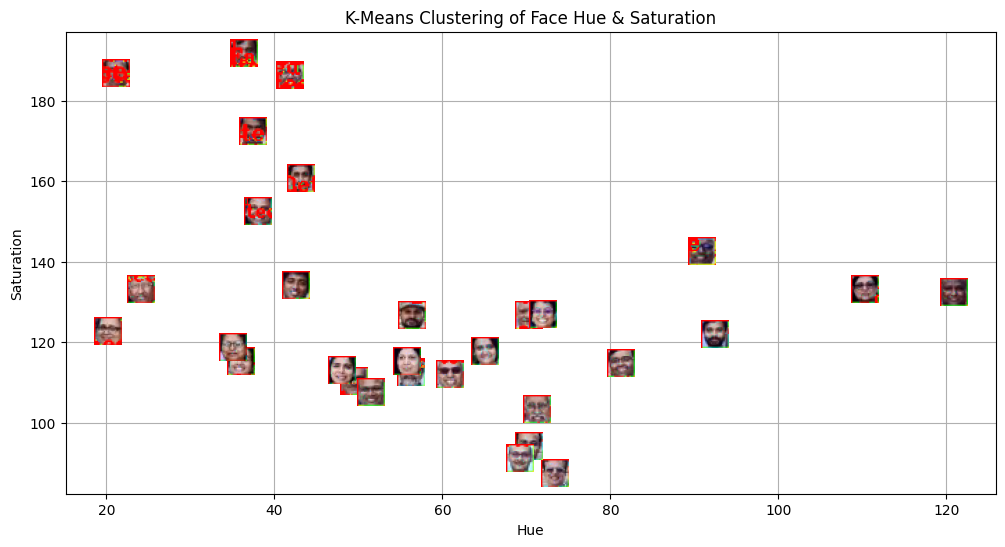

In [10]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

hue_saturation = []
face_images = []  # To store detected face images

# Extract face region features (Hue and Saturation)
for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]  # Crop face from HSV image
    hue = np.mean(face[:, :, 0])  # mean hue
    saturation = np.mean(face[:, :, 1])  # mean saturation
    hue_saturation.append((hue, saturation))
    face_images.append(face)  

hue_saturation = np.array(hue_saturation)

kmeans = KMeans(n_clusters=3, random_state=42)  # k = 3 
kmeans.fit(hue_saturation)  

centroids = kmeans.cluster_centers_
labels = kmeans.labels_


fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', label=f'Cluster {labels[i]}')

plt.xlabel("Hue")
plt.ylabel("Saturation")  
plt.title("K-Means Clustering of Face Hue & Saturation")  
plt.grid(True)
plt.show()
wandb.log({"Clustering of different faces are(Hue-saturation)": wandb.Image(fig)})

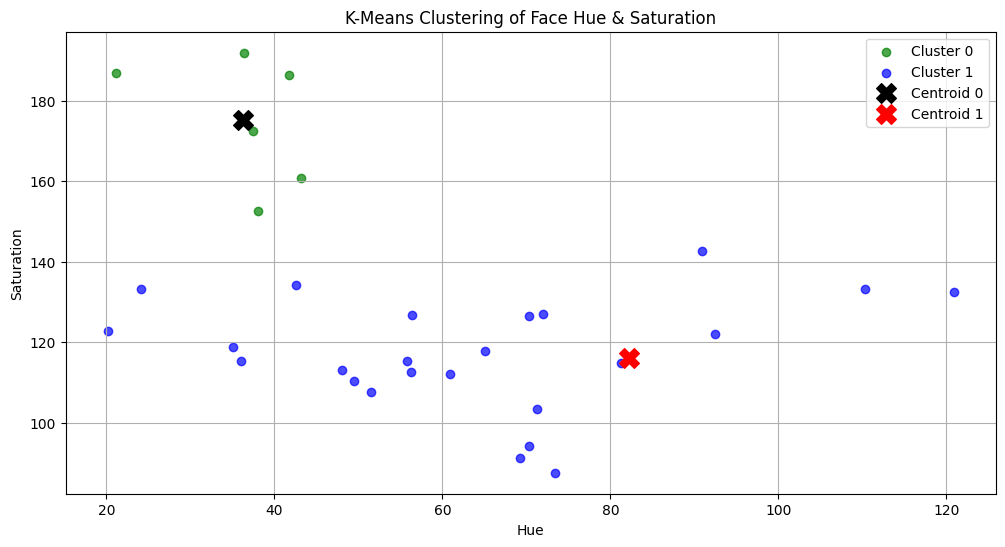

In [11]:
legend_labels = []

cluster_0_points = []
cluster_1_points = []

# scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Separate points based on cluster labels
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
cluster_1_points = np.array(cluster_1_points)

# cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label="Cluster 0", alpha=0.7)
# cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label="Cluster 1", alpha=0.7)
# centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]


plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='X', s=200, label="Centroid 0")
plt.scatter(centroid_1[0], centroid_1[1], color='red', marker='X', s=200, label="Centroid 1")
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("K-Means Clustering of Face Hue & Saturation")
plt.legend()
plt.grid(True)
plt.show()
wandb.log({"Clustering of Detected Faces, legend lables": wandb.Image(fig)})

In [12]:
template_img = cv2.imread("Dr_Shashi_Tharoor.jpg")
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY) 


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
template_faces = face_cascade.detectMultiScale(template_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)  # green rectangle 


cv2.imshow("Detected Face(s) in Template Image", template_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
wandb.log({"Faces detected": wandb.Image(template_img)})

Template Hue: 66.77281875, Template Saturation: 90.50254375
Predicted Cluster: 1


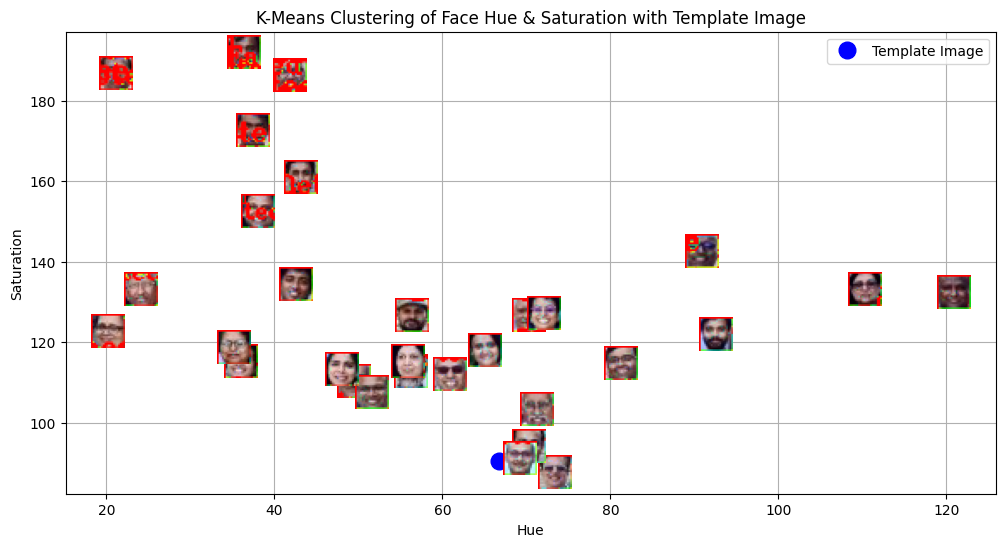

In [13]:
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# mean hue and saturation
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

template_label = kmeans.predict([[template_hue, template_saturation]])[0]


print(f"Template Hue: {template_hue}, Template Saturation: {template_saturation}")
print(f"Predicted Cluster: {template_label}")


fig, ax = plt.subplots(figsize=(12, 6))

for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'  # Assign color based on cluster
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB), zoom=1.2)
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)


plt.plot(template_hue, template_saturation, 'o', markersize=12, color='blue', label="Template Image")

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("K-Means Clustering of Face Hue & Saturation with Template Image")
plt.grid(True)
plt.legend()
plt.show()
wandb.log({"Clustering of template image(Hue-Saturation)": wandb.Image(fig)})

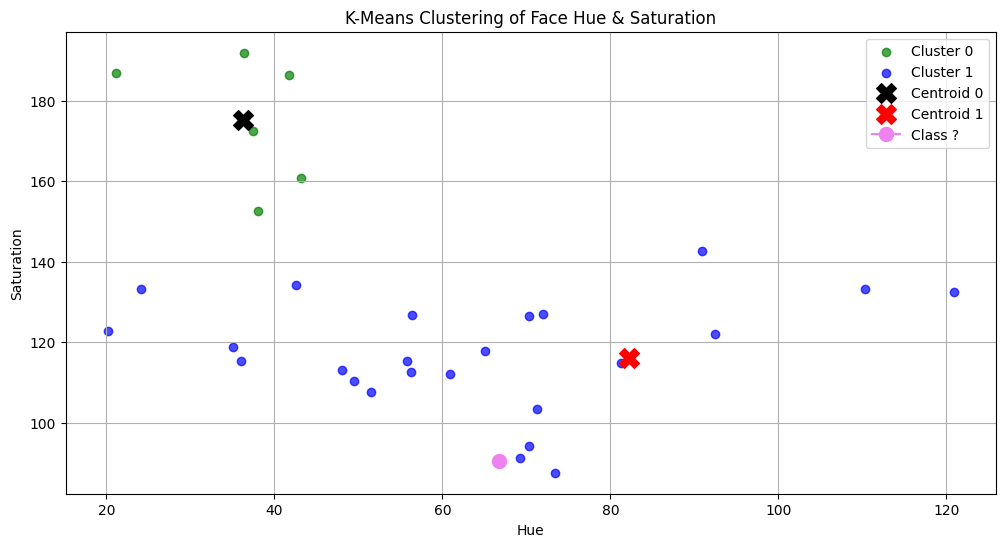

In [14]:
legend_labels = []
cluster_0_points = []
cluster_1_points = []

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
cluster_1_points = np.array(cluster_1_points)

# cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label="Cluster 0", alpha=0.7)
# cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label="Cluster 1", alpha=0.7)
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]

# centroids
plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='X', s=200, label="Centroid 0")
plt.scatter(centroid_1[0], centroid_1[1], color='red', marker='X', s=200, label="Centroid 1")

#  template image as violet dot
plt.plot(template_hue, template_saturation, marker='o', c='violet', markersize=10, label='Class ?')
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("K-Means Clustering of Face Hue & Saturation")
plt.legend()
plt.grid(True)
plt.show()
wandb.log({"Clusters and Centroids": wandb.Image(fig)}) 

### Report

### 1. What the common distance metrics used in distance-based classification algorithms? 

Some commonly used distance metrics in distance-based classification algorithms are:
- Euclidean Distance
- Manhattan Distance (city block distance)
- Minkowski Distance
- Cosine Distance
- Hamming Distance

### 2. What are some real-world applications of distance-based classification algorithms? 

Distance based algorithms are being used in multiple disciplines. In finance, healthcare, image processing, recommendation systems, etc.

In the realm of finance the algorithms are being used in the following manner.
1. K-nearest neighbor (KNN) is used for stock market prediction. It forecasts stock prices by finding the most similar historical situations ("neighbors") based on distance metrics. KNN helps identify patterns in stock data to predict future price movements.
2. Several distance-based classifiers are applied for credit scoring like K-nearest neighbor (KNN), Random Forest and Support Vector Machine (SVM)

Fraud detection is done by K-nearest neighbors (KNN) and K-means clustering as 
1. KNN classifies new transactions as fraudulent or legitimate based on similarity to known cases
2. K-means groups transactions into clusters to identify anomalous patterns

For text categorization tasks like email classification KNN is used. It classifies documents by finding the most similar labeled documents based on text features. KNN achieved high accuracy in categorizing emails into predefined categories.

### 3. Explain various distance metrics

- Euclidean Distance is derived from Pythagorean theorem. It is used to find straight line distance between 2 co-ordinates.


- Manhattan Distance is used to sum the absolute differences of coordinates. It is ideal for grid-like structures or high-dimensional spaces.
**Formula: sum(|pi - qi|)**


- Minkowski Distance is the generalization of all distance metrics ( likw Euclidean, Manhattan distances, etc with varying values of p). The parameter p is to vary the distance norm.
**Formula: (sum(|pi - qi|^p))^(1/p)**


- Cosine Distance is used to measure the similarity between vectors based on their angle. It is usually used in text analysis and document similarity. 
**Formula: 1 - cos(θ), where θ is the angle between vectors**


- Hamming Distance counts the number of positions where two binary strings differ.Used when data is one-hot encoded

### 4. What is the role of cross validation in model performance? 


Cross-validation is necessary in ensuring reliable model performance as it avoiding overfitting as it detect if a model is learning noise in the training data rather than generalizing well.It is used to see comparsions of different models or algorithms based on their performance on unseen data [test data]. It also helps in finding the right balance between model complexity and generalization ability.

### 5. Explain variance and bias in terms of KNN? 

1. Variance:
- Decreases as K increases
- For small K values, decision boundaries are complex and jagged which implies high variance
- High variance means the model is sensitive to small fluctuations in the training data

2. Bias:
- Increases as K increases
- For large K values, the decision boundaries become simpler and smoother which indicates higher bias
- High bias means the model may not capture the underlying patterns in the data well

The optimal K value strikes a balance between bias and variance, minimizing the overall error. 